In [29]:
import os

import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
import torchvision.models as models

from utils import load_all_set, load_each_set, load_image

## seed value

In [7]:
IN_HEIGHT, IN_WIDTH = 224, 224

RESOURCE = "GPU"

RANDOM_SEED = 46

EPOCH = 100
BATCH_SIZE =  64
lr = 1e-3
EARLY_STOP = 20

"""
model name
-resnet50
-resnet50_pretrained
-vgg19
-vgg19_pretrained
"""
model_name = 'resnet50'

dir_name = f'result/{model_name}'

if not os.path.exists(dir_name):
    os.mkdir(dir_name)

model_path = f'{dir_name}/{model_name}.pth'
acc_path = f'{dir_name}/acc.png'
loss_path = f'{dir_name}/loss.png'
cm_path = f'{dir_name}/confusion_matrix.png'

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

if RESOURCE == "CPU":
    device = torch.device("cpu")
    torch.manual_seed(RANDOM_SEED)
elif RESOURCE == "GPU":
    device = torch.device("cuda")
    torch.cuda.manual_seed(RANDOM_SEED)

# Install dataset

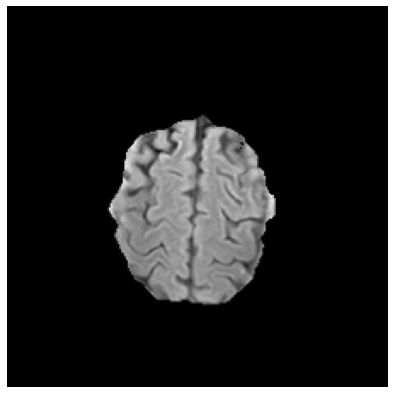

In [28]:
x_train, y_train, x_val, y_val, x_test, y_test = load_all_set()

plt.figure(figsize=(7,7))
plt.axis('off')
plt.imshow(x_train[0], cmap='gray')

In [5]:
class MyDataset(Dataset):
    def __init__(self, xs, ys, transforms=None):
        self.xs = xs
        self.ys = ys
        self.transforms = transforms
        self.data_num = len(xs)

    def __len__(self):
        return self.data_num

    def __getitem__(self, idx):
        x = self.xs[idx]
        y = self.ys[idx]

        if self.transforms:
            x = self.transforms(x)
        
        return x, y

In [9]:
model = models.resnet50(pretrained=False)

model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Sequential(nn.Linear(2048,1, bias=True),  nn.Sigmoid())

model = model.to(device)

criterion = nn.BCELoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=lr)

print(model)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Test

In [10]:
x_test, y_test = load_each_set('test')

transforms_test = transforms.Compose([
    transforms.ToTensor(),
])
dataset_test = MyDataset(xs=x_test, ys=y_test, transforms=transforms_test)

test_n = len(dataset_test)
print(test_n)

dataloader_test = DataLoader(dataset_test, batch_size=2*BATCH_SIZE)

model.load_state_dict(torch.load(model_path))
model.eval()

step = 0
batch_accuracy = 0
y_pred = []
with torch.no_grad():
    for inputs, targets in dataloader_test:
        n_batch = len(inputs)

        inputs = inputs.to(device)
        targets = targets.to(torch.float32)
        targets = targets.to(device)
        
        outputs = model(inputs)
        
        b_outputs = outputs.squeeze().cpu().numpy().copy()
        b_targets = targets.squeeze().cpu().numpy().copy()
        b_outputs = np.where(b_outputs>0.5, 1.0, 0.0)

        for i in b_outputs:
            y_pred.append([i])

        batch_accuracy += accuracy_score(b_targets, b_outputs)
        step += 1

test_accuracy = batch_accuracy / step
y_pred = np.array(y_pred)

print(f'{100*test_accuracy:.2f}%')

2458
94.07%


In [16]:
incorrect_dir = '{dir_name}/incorrect_mri/'

if os.path.exists(incorrect_dir):
    os.makedirs(incorrect_dir)

i = 0
for label, pred in zip(y_test, y_pred):
    if not label == pred:
        print(i)
    i += 1

132
139
149
154
242
245
256
307
329
352
386
392
405
416
417
437
449
485
491
506
523
538
575
635
642
661
743
758
787
794
810
841
856
863
930
982
1034
1044
1063
1089
1106
1183
1205
1236
1238
1248
1254
1272
1276
1302
1320
1323
1351
1377
1389
1403
1408
1428
1429
1433
1439
1445
1446
1454
1458
1462
1490
1492
1495
1511
1516
1540
1559
1563
1564
1565
1585
1596
1601
1646
1670
1677
1684
1685
1691
1713
1717
1719
1769
1780
1802
1803
1817
1819
1821
1829
1847
1863
1868
1871
1872
1935
1942
1943
1953
1964
1990
2006
2017
2023
2032
2045
2060
2072
2082
2128
2130
2134
2143
2148
2157
2188
2199
2204
2259
2278
2300
2304
2308
2312
2323
2325
2338
2343
2350
2351
2383
2388
2392
2401
2402
2409
2450
2451


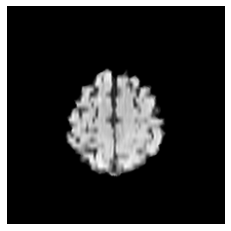

In [25]:
plt.axis('off')
plt.imshow(x_test[1], cmap='gray')
plt.savefig('')

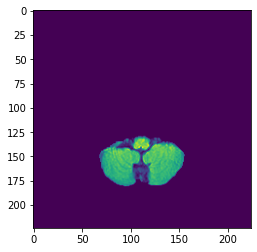

In [31]:
img = load_image('Dataset/train/0/1.png')
plt.imshow(img)

In [35]:
dirs = glob.glob('Dataset/test/0/' + '*.png')
print(dirs)

['Dataset/test/0/3602.png', 'Dataset/test/0/3091.png', 'Dataset/test/0/2096.png', 'Dataset/test/0/384.png', 'Dataset/test/0/896.png', 'Dataset/test/0/3801.png', 'Dataset/test/0/1098.png', 'Dataset/test/0/3090.png', 'Dataset/test/0/3087.png', 'Dataset/test/0/407.png', 'Dataset/test/0/2409.png', 'Dataset/test/0/4308.png', 'Dataset/test/0/409.png', 'Dataset/test/0/3325.png', 'Dataset/test/0/609.png', 'Dataset/test/0/4060.png', 'Dataset/test/0/4331.png', 'Dataset/test/0/3484.png', 'Dataset/test/0/1911.png', 'Dataset/test/0/2009.png', 'Dataset/test/0/1196.png', 'Dataset/test/0/2008.png', 'Dataset/test/0/3793.png', 'Dataset/test/0/2795.png', 'Dataset/test/0/2300.png', 'Dataset/test/0/2879.png', 'Dataset/test/0/1900.png', 'Dataset/test/0/1304.png', 'Dataset/test/0/3907.png', 'Dataset/test/0/1071.png', 'Dataset/test/0/3620.png', 'Dataset/test/0/2790.png', 'Dataset/test/0/3319.png', 'Dataset/test/0/2089.png', 'Dataset/test/0/3487.png', 'Dataset/test/0/1181.png', 'Dataset/test/0/1231.png', 'Data

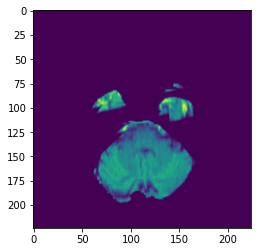

In [36]:
plt.imshow(x_test[0])